In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import pickle

import xgboost as xgb


## Input data

In [2]:
df = pd.read_csv('../Dataset/encoded_data.csv')
df.head(2)


,originalRate,size,baseOccupancy,maxChildOccupancy,maxChildAge,isBreakfastIncluded,isWifiIncluded,isRefundable,hasLivingRoom,starRating,...,Point_MUSEUM,Point_GALLERY,Point_PLACE_OF_WORSHIP,Point_TRAIN_STATION,Point_ZOO,Point_ENTERTAINMENT,Point_GARDEN,Point_THEATER,Point_STORE,Point_SCHOOL
0,1227273,46.0,3,1,5,1,1,1,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,596694,31.0,2,1,5,0,1,1,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = df.drop('originalRate', axis=1)
y = df['originalRate']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.22, random_state=123)

trainRatio = round(X_train.shape[0]/len(df), 2)*100
valRatio = round(X_val.shape[0]/len(df), 2)*100
testRatio = round(X_test.shape[0]/len(df), 2)*100

# print row each length of train, validation and test set
print("Columns: ", X_train.shape[1])
print("-"*15)
print(f"Train set\t: {X_train.shape[0]} ({trainRatio}%)")
print(f"Val set\t\t: {X_val.shape[0]} ({valRatio}%)")
print(f"Test set\t: {X_test.shape[0]} ({testRatio}%)")


Columns:  358
---------------
Train set	: 3346 (70.0%)
Val set		: 944 (20.0%)
Test set	: 477 (10.0%)


## Train data with XGBoost

In [5]:
# Train the data with XGBoost
eval_set = [(X_val, y_val)]

xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=10,

)
xg_reg.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Model Evaluation  

In [6]:
print('Train evaluation')
preds = xg_reg.predict(X_train)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_train, preds), 3))
print('-'*20)

print('Test evaluation')
preds = xg_reg.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_test, preds), 3))

Train evaluation
RMSE:  322,428
R2:  0.931
--------------------
Test evaluation
RMSE:  525,128
R2:  0.836


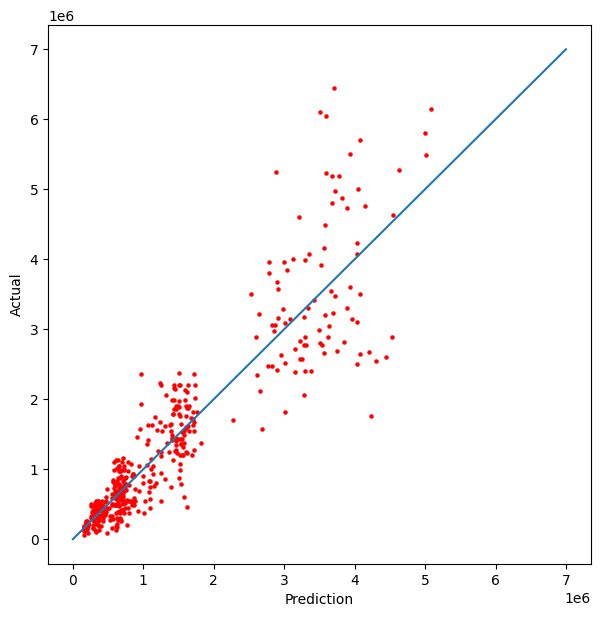

In [7]:
plt.figure(figsize=(7, 7))
plt.scatter(preds, y_test, color='r', s=5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.plot([0, 7e6], [0, 7e6])
plt.savefig('../Picture/prediction.png', bbox_inches='tight', dpi=400)
plt.show()

## Cross validation using grid search

In [8]:
import numpy as np
# Hyperparameter tuning
parameters = {
    'colsample_bytree': [0.7], # np.arange(0.6,1,0.1),
    'learning_rate': [0.1],  # [0.1, 0.15],
    'max_depth': [43], # np.arange(3,50,10),
    'min_child_weight': [9], # np.arange(1,10,1),
    'subsample': [0.9],  # np.arange(0.5,1,0.1),
    'reg_alpha': [5], # np.arange(0,10,1),
    'reg_lambda': [6] # np.arange(0,10,1),
}

scoring = ['neg_root_mean_squared_error', 'r2']


In [9]:
# Set up GridSearchCV
grid = GridSearchCV(
    xg_reg,
    parameters,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    refit='neg_root_mean_squared_error',
    verbose=3
)
grid.fit(X_train, y_train, eval_set=eval_set, verbose=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [43], 'min_child_weight': [9],
                         'reg_alpha': [5], 'reg_lambda': [6],
                         'subsample': [0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=3)

In [10]:
grid.best_estimator_


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=43, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [11]:
bestParams = grid.best_params_
# save best parameters dictionary with pickle
pickle.dump(bestParams, open('../Notebook/Variable/bestParams.pkl', 'wb'))

bestParams


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 43,
 'min_child_weight': 9,
 'reg_alpha': 5,
 'reg_lambda': 6,
 'subsample': 0.9}

In [12]:
abs(grid.best_score_)


499623.0287265105

In [13]:
# refit the model with the best parameters into bestModel
bestModel = grid.best_estimator_.fit(
    X_train, y_train, eval_set=eval_set, verbose=False)

### Model Evaluation

In [14]:
print('Train evaluation')
preds = bestModel.predict(X_train)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
print('RMSE: ', '{0:,.0f}'.format(rmse))
print('R2: ', round(r2_score(y_train, preds), 3))
print('-'*20)

print('Test evaluation')
preds = bestModel.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
rmse = '{0:,.0f}'.format(rmse)
r2 = round(r2_score(y_test, preds), 3)
print('RMSE: ', rmse)
print('R2: ', r2)

Train evaluation
RMSE:  148,022
R2:  0.985
--------------------
Test evaluation
RMSE:  509,959
R2:  0.846


In [15]:
score = {
    'RMSE': rmse,
    'R2': r2
}
pickle.dump(score, open('../Notebook/Variable/score.pkl', 'wb'))


In [16]:
# save the model with pickle
with open('../Model/bestModel.pkl', 'wb') as file:
    pickle.dump(bestModel, file)


### Plotting the prediction

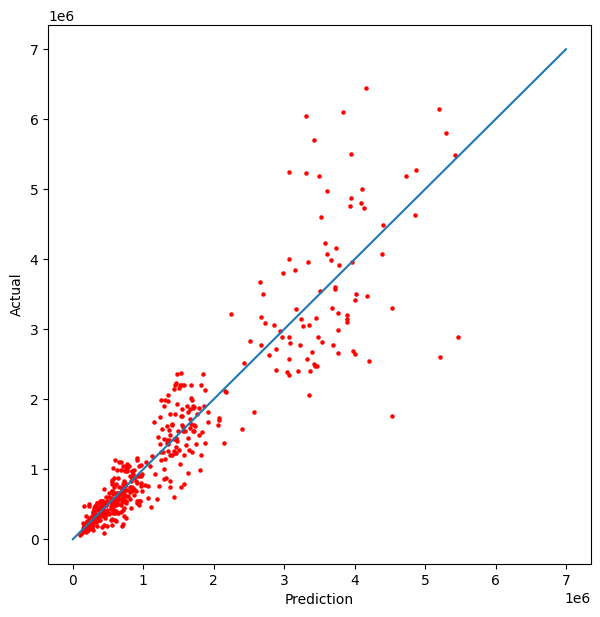

In [17]:
plt.figure(figsize=(7, 7))
plt.scatter(preds, y_test, color='r', s=5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.plot([0, 7e6], [0, 7e6])
plt.savefig('../Picture/grid_prediction.png', bbox_inches='tight', dpi=400)
plt.show()

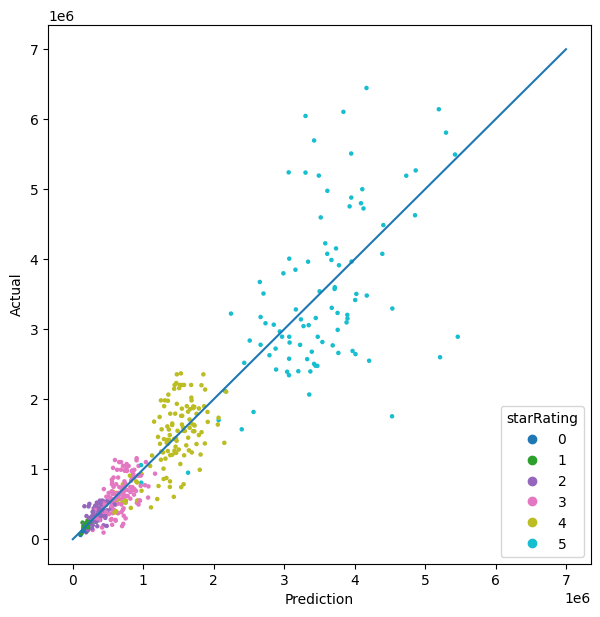

In [18]:
# create scatter plot like one above but color code by the 'starRating' column
plt.figure(figsize=(7, 7))
scatter = plt.scatter(preds, y_test, c=X_test['starRating'], cmap='tab10', s=5)
# create a color code legend
plt.legend(*scatter.legend_elements(), loc="lower right", title="starRating")
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.plot([0, 7e6], [0, 7e6])
plt.savefig('../Picture/grid_prediction_color.png',
            bbox_inches='tight', dpi=400)
plt.show()

### Feature importance

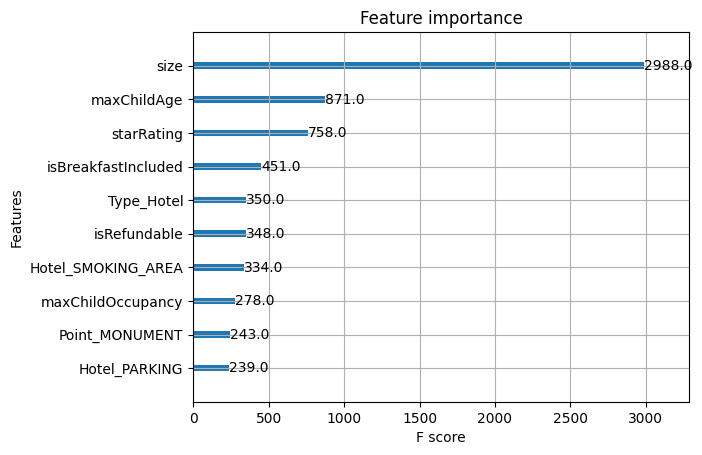

In [19]:
xgb.plot_importance(bestModel, max_num_features=10)
plt.savefig('../Picture/feature_importance.png', bbox_inches='tight', dpi=400)

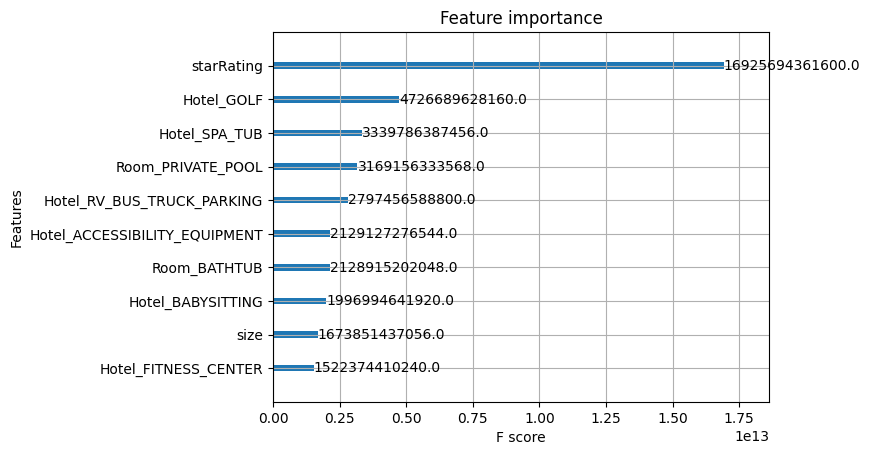

In [20]:
xgb.plot_importance(bestModel, max_num_features=10, importance_type='gain')
plt.savefig('../Picture/feature_importance_gain.png',
            bbox_inches='tight', dpi=400)

### Tree visualization

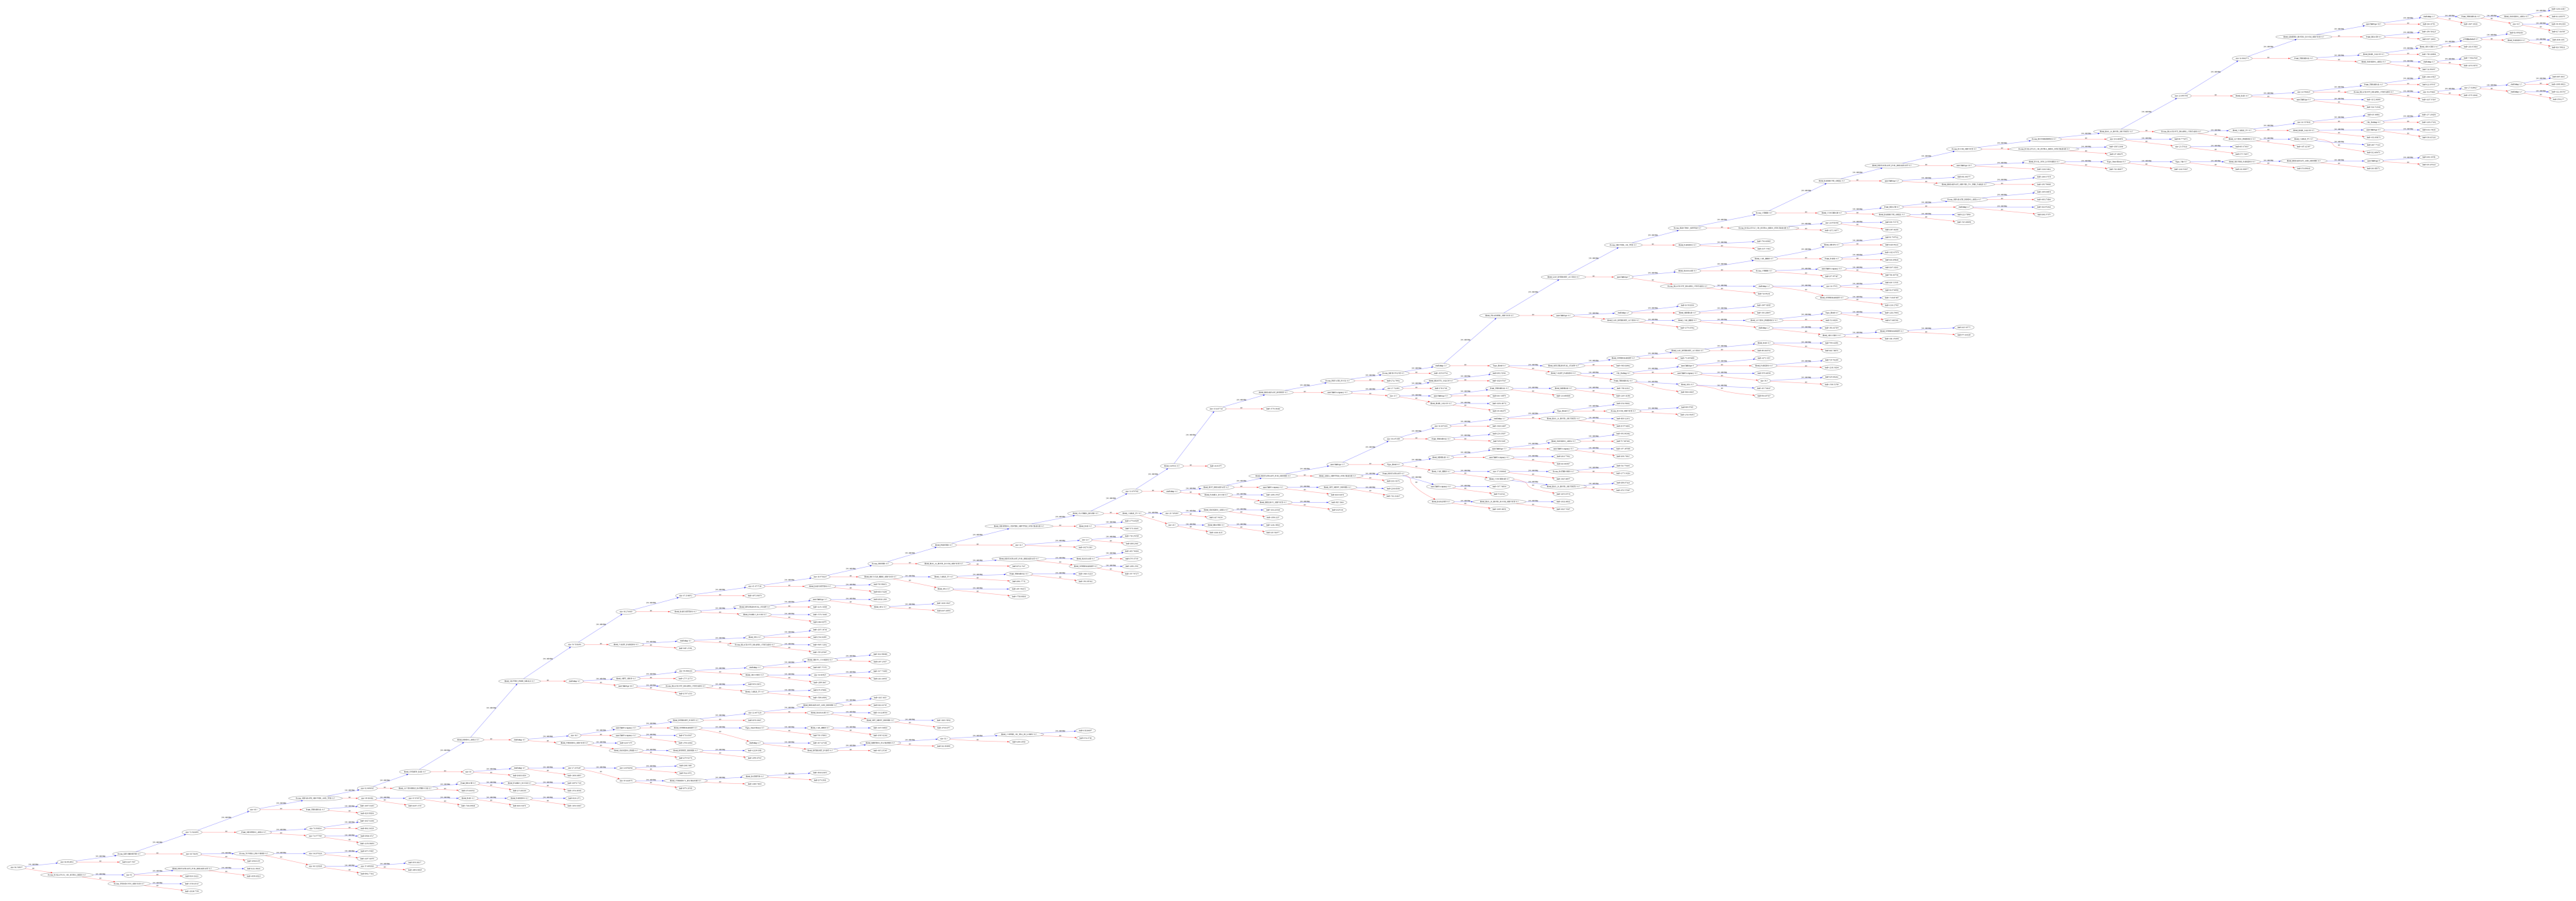

In [21]:
from xgboost import plot_tree

plot_tree(bestModel, rankdir='LR', num_trees=bestModel.best_iteration)
fig = plt.gcf()
fig.set_size_inches(50, 25, forward=True)
fig.savefig('../Picture/tree.png', bbox_inches='tight', dpi=300)

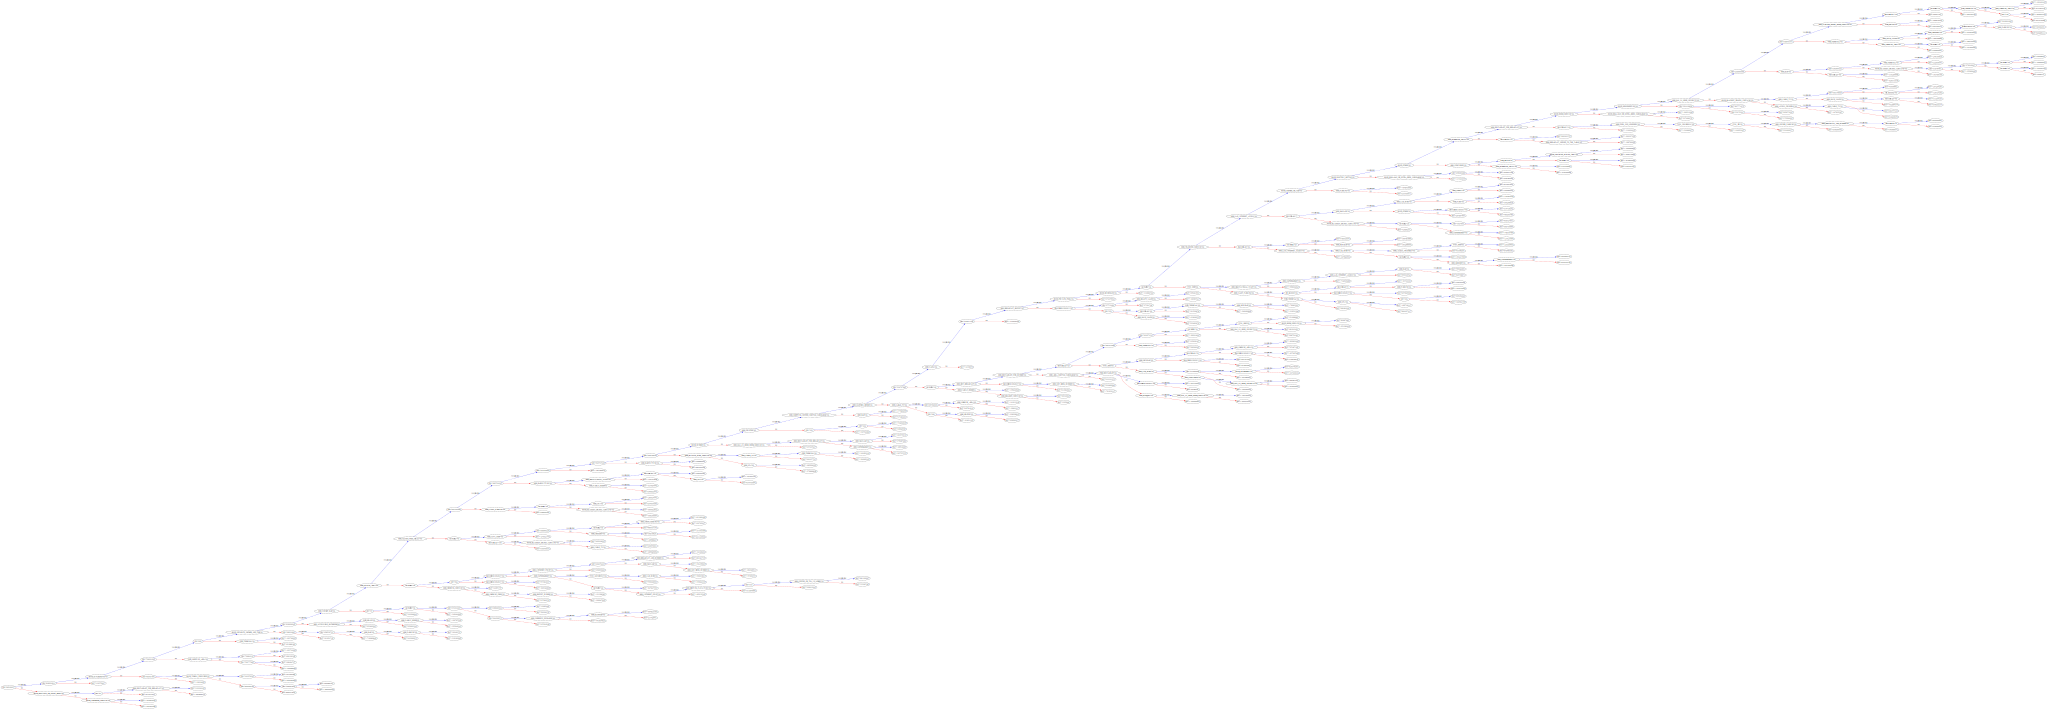

In [22]:
# plot the tree with graphviz
from xgboost import to_graphviz
to_graphviz(bestModel, num_trees=bestModel.best_iteration, rankdir='LR')
